In [22]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import *
from utils import plot
%matplotlib inline

## Funções de ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

## Funções de custo

In [3]:
#Classificação binária
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    
    return -np.mean(y*np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1 - y)*np.log(1 - y_sigmoid))

#Classificação multiclasse
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

#Regressão
def mae(y, y_pred,derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred,derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred)**2)

## Inicialização dos pesos

In [4]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0 / (rows + cols))
    return limit * np.random.randn(rows, cols) - limit

In [5]:
#Regularização
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs*(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

#Learning rate decay
def none_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate  * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

#Batch generator
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
        
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

## Implementação

In [10]:
class Layer():
    def __init__(self, input_dim, output_dim, weights_initializer=random_normal, biases_initializer=ones,activation=linear, droput_prob=0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input_dim = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.droput_prob = droput_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.is_trainable = is_trainable
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None,None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None
    
class NeuronNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3,lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1,momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None, batch_norm=False, bn_decay=0.9):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        loss_val2 = []
        loss_train2 = []
        
        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedfoward(x_batch)
                self.__backprop(y_batch, y_pred)
            
            loss_val = self.cost_func(y_val, self.predict(x_val))
            loss_val2.append(loss_val)
            loss_train = self.cost_func(y_train, self.predict(x_train))
            loss_train2.append(loss_train)
            
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return loss_val2, loss_train2
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_train2.append(loss_train)
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([layer.reg_func(layer.weights) * layer.reg_strength for layer in self.layers])
                print("Epoch {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs,loss_train, loss_reg,loss_train+loss_reg, loss_val))
    
    def predict(self, x):
        return self.__feedfoward(x, is_training=False)
    
    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)
        
    def load(file_path):
        return pkl.load(open(file_path, 'rb'))
    
    def __feedfoward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer , next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_foward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer.droput_mask = np.random.binomial(1, 1.0 - current_layer.droput_prob, y.shape) / (1.0 - current_layer.droput_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer.droput_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            deactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer.droput_mask
            deactivation = batchnorm_backward(layer, deactivation) if layer.batch_norm else deactivation
            last_delta = np.dot(deactivation, layer.weights)
            layer._dweights = np.dot(deactivation.T, layer.input)
            layer._dbiases = 1.0 * deactivation.sum(axis=0, keepdims=True)
            
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = - self.learning_rate * layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights - self.learning_rate * layer._dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases

                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

In [7]:
def rand():
    return round(randint(0,1) + uniform(-0.1, 0.1),3)

def binaryToDecimal(n): 
    return int(n,2) 

n_instances = 1500
X = np.zeros((n_instances, 3), dtype=np.float32)
y = np.zeros(n_instances, dtype=np.int)


for i in range(n_instances):
    val = np.array([rand(), rand(), rand()])
    X[i] = val

    code = np.array([round(val[0]), round(val[1]), round(val[2])])
    label = np.array([code[0]*4 + code[1]*2 + code[2]])
    y[i] = label
    
oh = OneHotEncoder()
y_oh = oh.fit_transform(y.reshape(-1,1)).toarray()


X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1],8)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Softmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x) 
        x = self.fc2(x)
        return x

In [ ]:
model = Net()
criterion = torch.nn.MSELoss(reduction='sum')
learning_rate = 0.1
optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for i in range(1500):
    y_pred = model(X_train)

    loss = criterion(y_pred, y_train)

    if i % 100 == 99:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
for i in range(1000):
    y_pred = model(X_train)

    loss = criterion(y_pred, y_train)

    if i % 100 == 99:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [67]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf

In [ ]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 12, kernel_initializer="glorot_uniform", activation = 'linear', input_dim=X_train.shape[1]))
classifier.add(Dense(8, kernel_initializer="glorot_uniform", activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = classifier.fit(X_train, y_train, batch_size = 32, epochs = 150,validation_data=(X_val, y_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,min_delta=0.1, verbose=10)])

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Segunda questão

In [13]:
# A) XOR
a_data_X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
a_data_y = np.array([[0],[1],[1],[0]],dtype='float32')

X_train, X_val, X_test = a_data_X, a_data_X, a_data_X
y_train, y_val, y_test = a_data_y, a_data_y, a_data_y

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

(4, 2) (4, 1)


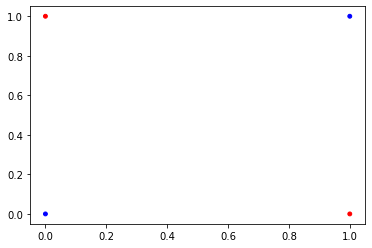

In [37]:

x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

In [45]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuronNetwork(cost_func=binary_cross_entropy, learning_rate=0.001)
nn.layers.append(Layer(input_dim=2, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=sigmoid))
nn.fit(x, y, epochs=100, batch_size=32, batch_norm=True)

Epoch    0/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   10/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   20/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   30/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   40/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   50/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   60/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   70/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   80/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch   90/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447
Epoch  100/100 loss_train: 0.80961447 + 0.00000000 = 0.80961447 loss_val = 0.80961447


Predições:
[[0.32252066]
 [0.35404585]
 [0.21075148]
 [0.22405771]]
Acurácia: 50.00%


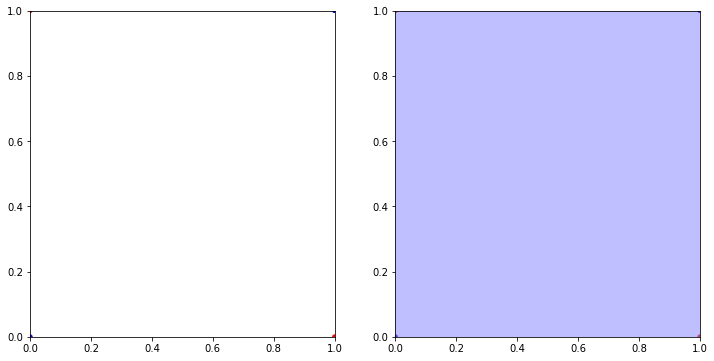

In [46]:
y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

In [44]:

images, labels = next(iter(trainloader))

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/nilbson/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/nilbson/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/nilbson/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [4, 1] at entry 0 and [4, 2] at entry 1


In [ ]:
cm

In [ ]:
classification_report(y_test, y_pred, output_dict=True) 